In [80]:
# Import libraries 
import os
import torch 
import pickle 
import matplotlib.pyplot as plt
import  time
import glob
from scipy.io import loadmat
import random
from random import seed, randint
from sklearn.model_selection import train_test_split
import pandas as pd
import sys
from queue import Queue
import numpy as np

In [81]:
global device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
import r2plus1d_ptv
from r2plus1d_ptv import create_r2plus1d
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import (
    RandomCrop,
    RandomResizedCrop,
)

class ReSizeVid():
    def __init__(self, size = (256, 256)):
        self.size = size
    
    def __call__(self, t_v):
        ll =  t_v.shape
        kk = torch.empty((ll[0], ll[1], ll[2], ll[3], self.size[0], self.size[1]))
        for i in range(ll[1]):
            kk[:, i,:,:,:,:] =  self.resize(t_v[0,i], self.size)
        return kk
    
    def resize(self, clip, target_size, interpolation_mode =  "bilinear"):
        assert len(target_size) == 2, "target size should be tuple (height, width)"
        return torch.nn.functional.interpolate(
            clip, size=target_size, mode=interpolation_mode
        )


def get_model(pt = 0, ModName = None):
    if ModName =='R2+1D':
        net = create_r2plus1d()
        if pt ==1:
            wt = torch.load('R2PLUS1D_16x4_R50.pyth', map_location=device)
            net.load_state_dict(wt["model_state"])
    return net 

class L2Norm(nn.Module):
    def forward(self, x):
        return x / x.norm(p=2, dim=1, keepdim=True)

In [83]:
import torch.nn as nn
def get_R_model(num_classes = 100, mlp = 0, ModName = None, pt = 0): # single layer only can add many layers if wanted
    if ModName == 'R2+1D':
        mod_frm_no = 16
        my_net = get_model(pt = pt, ModName = ModName)
        trx = transforms.Compose([ReSizeVid((224, 224))]) # r2+1 d 
        if mlp:
            my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-3], nn.Flatten(),
                                          nn.Linear(in_features=2048, out_features=num_classes, bias=True), nn.ReLU()
                                         )
        else:
            my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-3], nn.Flatten(), 
                                          nn.Linear(in_features=2048, out_features=2048, bias=True), nn.ReLU(),
                                          nn.Linear(in_features=2048, out_features=num_classes, bias=True), nn.ReLU()
                                         )
    return my_net, trx, mod_frm_no


def load_wt(net, pretrained_file='p3d_rgb_199.checkpoint.pth.tar'):
    weights=torch.load(pretrained_file, map_location=device)
    net.load_state_dict(weights)

    
def model_return(values = 0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ModName = 'R2+1D'
    my_net, trx, mod_frm_no = get_R_model(10, mlp = 1, ModName = ModName, pt = 0)
    if ModName =='R2+1D':
        my_net.blocks[5] = nn.Sequential(*list(my_net.blocks[5].children())[:-2], 
                                                      nn.Linear(in_features=2048, out_features=11, bias=True))
    if values == 0:
        load_wt(my_net, pretrained_file='../My_net_r2+1D_good_model_signle_.pth')
    else:
        load_wt(my_net, pretrained_file='../My_net_r2+1D_good_model.pth')
    return my_net, trx, mod_frm_no



In [84]:
# load videos

def get_files(path_dir = '../Data/Pickle_files'):
    dataPath = os.path.join(path_dir, '*.pkl')
    return glob.glob(dataPath)  # care about the serialization


def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key
    return "key doesn't exist"


In [85]:
class test_data():
    def __init__(self, temp, frm_no = 16):
        self.frm_no = frm_no
        self.temp = temp
        self.mini =  min(len(temp[0]), len(temp[2]), len(temp[1]))- 80
    def get_data_test(self, idx= None):
        if idx == None: idx = randint(0,self.mini)    
        x_v1, x_v2, x_v3 = self.temp[0][idx:idx+self.frm_no], self.temp[1][idx:idx+self.frm_no], self.temp[2][idx:idx+self.frm_no]
        ret = np.moveaxis(np.stack((x_v1, x_v2, x_v3), axis = 0), -1, -4)
        return ret.astype(np.float32)/255.0

In [86]:
def get_test_data( i  = 2 ):
    files = get_files(path_dir = '../Data/Pickle_files')
    files.sort()
    print(files)
    temp = []
    with open(files[i], 'rb') as f:
        temp.append(pickle.load(f)) 
    test_dat = test_data(temp =temp[0])
    print(files[i])
    return test_dat

In [87]:
i=1
files = get_files(path_dir = '../Data/Pickle_files')
print(files[i])

../Data/Pickle_files/Trial2_7_27_300_300-003.pkl


In [88]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def create_video_animation(videos, messages, interval=500):
    fig, axs = plt.subplots(1, len(videos), figsize=(len(videos) * 5, 5))

    def update(frame_idx):
        for i, ax in enumerate(axs):
            frame = videos[i][frame_idx, :, :, :]
            ax.clear()
            ax.imshow(frame)
            ax.axis('off')
            ax.set_title(messages[i])

    # Create animation
    animation = FuncAnimation(fig, update, frames=len(videos[0]), interval=interval, repeat=False)

    # Display the animation in Jupyter Notebook
    return HTML(animation.to_jshtml())
        

def main( test_dat, pos = 0):
    my_net_mv, trx, mod_frm_no = model_return(1)
    my_net_sv, trx, mod_frm_no = model_return(0)
    
    
    LabelDict= {'sitting':0, 'standing':1, 'lying_d':2, 'lying_u':3, 'walking':4, 'push_up':5, 'object_walk':6, 'object_pick':7, 'hand_wave':8, 'leg_exer':9, 'what':10}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
    vid_seg = test_dat.get_data_test(pos)
    vid_seg_pt= trx(torch.tensor(vid_seg).unsqueeze(0))
    my_net_mv.to(device)
    my_net_sv.to(device)
    s1 =  vid_seg_pt.to(device)
    
    with torch.no_grad():
        output_mv = my_net_mv(s1[0])
        output_sv = my_net_sv(s1[0])
        
    pred_mv = output_mv.argmax(dim = 1)
    pred_sv = output_sv.argmax(dim = 1)
    
    
    
    video1 =  vid_seg[0].transpose(1, 2, 3,0)
    video2 =  vid_seg[1].transpose(1, 2,3, 0)
    video3 =  vid_seg[2].transpose(1, 2, 3,0)
    
    
    videos = [video1, video2, video3]
    
    
    
    messages = ["\n"+get_key(LabelDict, pred_mv[0])+ "\n"+ get_key(LabelDict, pred_sv[0]),
                "\n"+get_key(LabelDict, pred_mv[1])+ "\n"+get_key(LabelDict, pred_sv[1]), "\n"+ get_key(LabelDict, pred_mv[2])+"\n"+get_key(LabelDict, pred_sv[2])]
    
    
    
    return videos, messages
    

def plot_function(videos, messages):
    fig, axs = plt.subplots(1, len(videos), figsize=(len(videos) * 5, 5))    
    def update(frame_idx):
        for i, ax in enumerate(axs):
            frame = videos[i][frame_idx, :, :, :]
            ax.clear()
            ax.imshow(frame)
            ax.axis('off')
            ax.set_title(messages[i], wrap = True)
    # Create animation
    animation = FuncAnimation(fig, update, frames=len(videos[0]), interval=500, repeat=False)
    plt.show()
    
# def main(pos = 1000):
    my_net_mv, trx, mod_frm_no = model_return(1)
    my_net_sv, trx, mod_frm_no = model_return(0)
    
    
    LabelDict= {'sitting':0, 'standing':1, 'lying_d':2, 'lying_u':3, 'walking':4, 'push_up':5, 'object_walk':6, 'object_pick':7, 'hand_wave':8, 'leg_exer':9, 'what':10}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_dat = get_test_data(1) # returns whole video
    vid_seg = test_dat.get_data_test(pos) # segmented the chunk of the video to predict
    vid_seg_pt= trx(torch.tensor(vid_seg).unsqueeze(0)) #pytorch version of the vid_seg
    my_net_mv.to(device)
    my_net_sv.to(device)
    s1 =  vid_seg_pt.to(device)

    with torch.no_grad():
        output_mv = my_net_mv(s1[0])
        output_sv = my_net_sv(s1[0])
        
    pred_mv = output_mv.argmax(dim = 1)
    pred_sv = output_sv.argmax(dim = 1)
    

    
    video1 =  vid_seg[0].transpose(1, 2, 3,0)
    video2 =  vid_seg[1].transpose(1, 2, 3,0)
    video3 =  vid_seg[2].transpose(1, 2, 3,0)
    videos = [video1, video2, video3]
    


    messages = [get_key(LabelDict, pred_mv[0])+ "\n"+ get_key(LabelDict, pred_sv[0]),
                get_key(LabelDict, pred_mv[1])+ "\n"+get_key(LabelDict, pred_sv[1]), get_key(LabelDict, pred_mv[2])+"\n"+get_key(LabelDict, pred_sv[2])]

    create_video_animation(videos, messages)

In [93]:
test_dat = get_test_data(1)

['../Data/Pickle_files/Ajagi_8_26_21_2_300_300-001.pkl', '../Data/Pickle_files/Trial2_7_27_300_300-003.pkl']
../Data/Pickle_files/Trial2_7_27_300_300-003.pkl


MovieWriter ffmpeg unavailable; using Pillow instead.


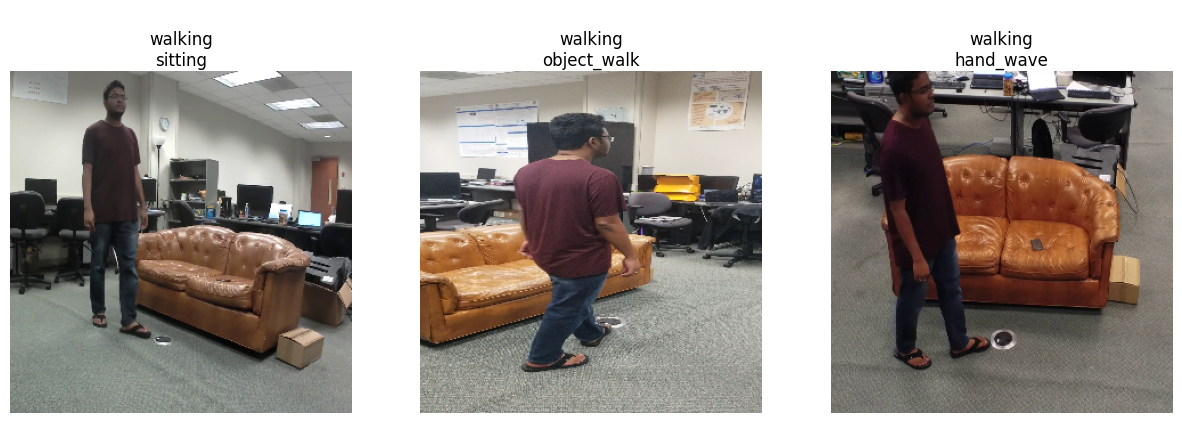

In [94]:

if __name__ == '__main__':
    
    for i in [2500]:
        videos, messages = main(test_dat, pos = i)
        fig, axs = plt.subplots(1, len(videos), figsize=(len(videos) * 5, 5))    
        def update(frame_idx):
            for i, ax in enumerate(axs):
                frame = videos[i][frame_idx, :, :, :]
                ax.clear()
                ax.imshow(frame)
                ax.axis('off')
                ax.set_title(messages[i], wrap = True)
        # Create animation
        animation = FuncAnimation(fig, update, frames=len(videos[0]), interval=500, repeat=False)   
        
        animation.save('animation'+ str(i)+'.gif')
        
        plt.show()
        
        